# Plot qPCR of RNA export with varying export tag copy number

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_tag_number"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_tag_number_Cq.csv"


cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

print(cq_raw.shape)
cq_raw.head()

(38, 13)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
0,A01,SYBR,mCherry,Unkn-01,Well1,Supernatant,34.516878,33.855151,0.584875,15.347779,1.186046,24.117839,7.870989
1,A02,SYBR,mCherry,Unkn-03,Well2,Supernatant,25.510410,25.334450,0.214983,4121.649385,3.615071,4625.404802,632.491254
2,A03,SYBR,mCherry,Unkn-05,Well3,Supernatant,23.347337,23.100214,0.257669,15792.372998,4.198447,18570.229188,2988.988325
3,A04,SYBR,mCherry,Unkn-07,Well4,Supernatant,22.523269,22.424550,0.244022,26344.904307,4.420697,28230.837761,4425.562083
4,A05,SYBR,mCherry,Unkn-09,Well5,Supernatant,22.080745,21.668722,0.363187,34677.234324,4.540044,45523.140247,9633.591828


In [5]:
# Load metadata (includes sample names)
infile = "../preprocessed_data/qPCR_data/qPCR_tag_number_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
print(metadata.shape)
metadata.head()

(6, 6)


,Sample,Condition,Exporter,Reporter,Exporter pID,Reporter pID
0,Well1,mCherry,Gag-MCP,mCherry,2.1,2.10
1,Well2,mCherry-MS2x2,Gag-MCP,mCherry-MS2x2,2.1,2.19
2,Well3,mCherry-MS2x4,Gag-MCP,mCherry-MS2x4,2.1,2.20
3,Well4,mCherry-MS2x6,Gag-MCP,mCherry-MS2x6,2.1,2.21
4,Well5,mCherry-MS2x8,Gag-MCP,mCherry-MS2x8,2.1,2.22


# Preprocess data

## Calculate total starting molecules

In [6]:
# Calculate normalization for input volume
DILUTION_FACTORS = (400/140) * (42/20) * (61/10) * (20/1)

In [7]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [8]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [9]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
Well1,24.117839,7.870989,2.963207e+06,9.670589e+05
Well2,4625.404802,632.491254,5.682944e+08,7.771023e+07
Well3,18570.229188,2988.988325,2.281607e+09,3.672382e+08
Well4,28230.837761,4425.562083,3.468546e+09,5.437410e+08
Well5,45523.140247,9633.591828,5.593142e+09,1.183619e+09
Well6,43614.806572,3220.923448,5.358677e+09,3.957346e+08


## Censor by lower limit of quantification

In [10]:
# Because no signal was detected in any of the no template control (NTC) wells, we calculate the
# lower limit of quantification based on the detection limit of a single molecule present
# as input to the qPCR reaction.

LOD = DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 122863.71681698623


In [11]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

# Visualize RNA export with varying numbers of export tags

In [12]:
# Choose samples
index_ordered = ["Well1", "Well2", "Well3", "Well4", "Well5", "Well6"]

In [13]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

# Set label
# summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(6, 5)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored
Sample,,,,,
Well1,24.117839,7.870989,2.963207e+06,9.670589e+05,2.963207e+06
Well2,4625.404802,632.491254,5.682944e+08,7.771023e+07,5.682944e+08
Well3,18570.229188,2988.988325,2.281607e+09,3.672382e+08,2.281607e+09
Well4,28230.837761,4425.562083,3.468546e+09,5.437410e+08,3.468546e+09
Well5,45523.140247,9633.591828,5.593142e+09,1.183619e+09,5.593142e+09
Well6,43614.806572,3220.923448,5.358677e+09,3.957346e+08,5.358677e+09


In [14]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(index_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(18, 17)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
0,A01,SYBR,mCherry,Unkn-01,Well1,Supernatant,34.516878,33.855151,0.584875,15.347779,1.186046,24.117839,7.870989,1.885685e+06,2.963207e+06,9.670589e+05,1.885685e+06
1,A02,SYBR,mCherry,Unkn-03,Well2,Supernatant,25.510410,25.334450,0.214983,4121.649385,3.615071,4625.404802,632.491254,5.064012e+08,5.682944e+08,7.771023e+07,5.064012e+08
2,A03,SYBR,mCherry,Unkn-05,Well3,Supernatant,23.347337,23.100214,0.257669,15792.372998,4.198447,18570.229188,2988.988325,1.940310e+09,2.281607e+09,3.672382e+08,1.940310e+09
3,A04,SYBR,mCherry,Unkn-07,Well4,Supernatant,22.523269,22.424550,0.244022,26344.904307,4.420697,28230.837761,4425.562083,3.236833e+09,3.468546e+09,5.437410e+08,3.236833e+09
4,A05,SYBR,mCherry,Unkn-09,Well5,Supernatant,22.080745,21.668722,0.363187,34677.234324,4.540044,45523.140247,9633.591828,4.260574e+09,5.593142e+09,1.183619e+09,4.260574e+09


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


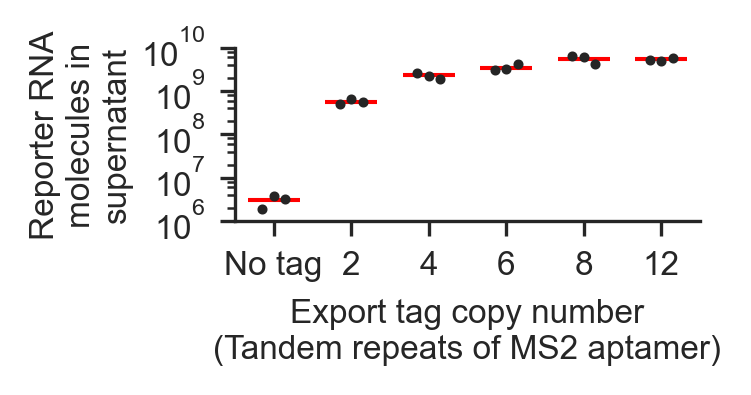

In [15]:
# Make simple swarm plot

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=(2,0.75))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e6, 1e10)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(ax=ax, x=x, y=y, marker="_", s=150, color="r")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=2)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0, 1, 2, 3, 4, 5])
xticklabels = ["No tag", 2, 4, 6, 8, 12]
ax.set_xticklabels(xticklabels)

ax.set_xlabel("Export tag copy number\n(Tandem repeats of MS2 aptamer)")

# Draw line indicating limit of detection
ax.axhline(LOD, ls="--", color="k", lw=1)

sns.despine()

save_figure(fig, "line_swarm_MS2_copy_number")

# Report values

In [16]:
# Absolute number of molecules
print(summary_subset["RNA molecules"])

Sample
Well1    2.963207e+06
Well2    5.682944e+08
Well3    2.281607e+09
Well4    3.468546e+09
Well5    5.593142e+09
Well6    5.358677e+09
Name: RNA molecules, dtype: float64


In [17]:
# Report relative rates
print(summary_subset["RNA molecules"]/summary_subset["RNA molecules"].loc["Well5"])

Sample
Well1    0.000530
Well2    0.101606
Well3    0.407929
Well4    0.620143
Well5    1.000000
Well6    0.958080
Name: RNA molecules, dtype: float64
